In [15]:
from src.data.esophagus.esophagus_data import EsophagusData
from src.preprocess import get_preprocessed_data
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import shap
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import *
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [2]:
def get_shap_values(X_test, X_train, model):
    if model.__class__.__name__ == 'LogisticRegression':
        explainer = shap.LinearExplainer(model, X_train)
    else:
        if hasattr(model, "predict_proba"):
            f = lambda x: model.predict_proba(x)[:, 1]
            explainer = shap.KernelExplainer(f, X_train)
        else:
            explainer = shap.KernelExplainer(model.decision_function, X_train)
    return explainer.shap_values(X_test)

# Hyperparams

In [3]:
cv_splits = 8
seed = 89

# Dataset

In [4]:
data = EsophagusData()
data.parse(drop_columns=True, feature_set=None, drop_missing_value=0, exploration=False, external_validation=True)
X, Y = get_preprocessed_data(data, verbose=False, validation=False, correlation_threshold=0.85, missing_threshold=0.5)
X_val, Y_val = get_preprocessed_data(data, verbose=False, validation=True, correlation_threshold=0.85)
print(X_val.columns.difference(X.columns))
# Get rid of extra columns introduced by values in validation dataset
X_val = X_val.drop(set(X_val.columns.difference(X.columns)), axis=1)

[]
['Herzrhythmusstörung', 'aHt', 'Autoimmunerkrankung', 'Gamma-GT', 'inability_ CTX_within_4weeks', 'Pneumonie', 'paVk', 'Gewicht in kg', 'Herzinsuffizienz', 'Lungenerkrankung', 'inabitity_CTX_within _6weeks', 'Pylorusstenose', 'Herzklappenerkrankung', 'MittlereTemp.[°C]', 'Diabetes', 'Gerinnungsstörung', 'Sonnen-scheindauer[h]', 'Sex', 'KHK', 'AI gesamt', 'Nieder-schlag[l/m2]', 'Re-Admission ICU', 'Hepatose', 'ZNS_NE', 'Infektionserkrankung']
['Any_malignancy', 'Diabetes_without_chronic_complications']
2 features with a single unique value.

[]
0 features with greater than 0.50 missing values.



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4 features with a correlation greater than 0.85.

['Hämatokrit', 'INR', 'Erythrozyten', 'HIV_infection_no_AIDS']
Removed 6 features
['Histologie', 'Lokalisation', 'Vorbehandlung', 'Tpre', 'Npre', 'ASA', 'GFR']
Running IterativeImputer...
Normalising numerical features...
Class distributions for 409 data points, validation=False:
Endpoint Death_within_primary_stay:
	Class "0":	392 (0.958)
	Class "1":	17 (0.042)


Endpoint 30d_mortality:
	Class "0":	400 (0.978)
	Class "1":	9 (0.022)


Endpoint 90d_mortality:
	Class "0":	391 (0.956)
	Class "1":	18 (0.044)


['Any_malignancy', 'Diabetes_without_chronic_complications']
2 features with a single unique value.

[]
0 features with greater than 0.50 missing values.



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


4 features with a correlation greater than 0.85.

['Hämatokrit', 'INR', 'Erythrozyten', 'HIV_infection_no_AIDS']
Removed 6 features
['Histologie', 'Lokalisation', 'Vorbehandlung', 'Tpre', 'Npre', 'ASA', 'GFR']
Running IterativeImputer...
Normalising numerical features...
Class distributions for 148 data points, validation=True:
Endpoint Death_within_primary_stay:
	Class "0":	133 (0.899)
	Class "1":	15 (0.101)


Endpoint 30d_mortality:
	Class "0.0":	142 (0.959)
	Class "1.0":	6 (0.041)


Endpoint 90d_mortality:
	Class "0":	135 (0.912)
	Class "1":	13 (0.088)


Index(['ASA_5.0', 'Histologie_0', 'Lokalisation_0'], dtype='object')


In [5]:
feature_names = X.columns

In [6]:
feature_names

Index(['AIDS', 'Cerebrovascular_disease', 'Chronic_pulmonary_disease',
       'Congestive_heart_failure', 'Diabetes_with_chronic_complications',
       'Geschlecht', 'Hemiplegia_or_paraplegia', 'Liver_disease_mild',
       'Liver_disease_moderate_to_severe', 'Metastatic_solid_tumor',
       'Myocardial_infarction', 'Peptic_ulcer_disease',
       'Peripheral_vascular_disease', 'Renal_disease_mild_to_moderate',
       'Renal_disease_severe', 'Rheumatic_disease', 'Histologie_1',
       'Histologie_2', 'Histologie_3', 'Lokalisation_cervikal',
       'Lokalisation_mittlerer_thorakaler_ Abschnitt',
       'Lokalisation_oberer_thorakaler_Abschnitt',
       'Lokalisation_oesophagogastraler_Übergang',
       'Lokalisation_unterer_thorakaler_Abschnitt', 'Vorbehandlung_0',
       'Vorbehandlung_1', 'Vorbehandlung_2', 'Vorbehandlung_3', 'Tpre_0',
       'Tpre_T0', 'Tpre_T1', 'Tpre_T2', 'Tpre_T3', 'Tpre_T4', 'Tpre_Tis',
       'Tpre_Tx', 'Npre_0', 'Npre_N0', 'Npre_N1', 'Npre_N2', 'Npre_N3',
       

In [7]:
feature_names_list = list(feature_names)
replacements = {
    'AgetAtSurgery': 'Age',
    'AIDS': 'Acquired Immunodeficiency Syndrome',
    'aPTT': 'Activated partial thromboplastin time',
    'ASA_0.0': 'ASA class 0',
    'ASA_1.0': 'ASA class 1',
    'ASA_2.0': 'ASA class 2',
    'ASA_3.0': 'ASA class 3',
    'ASA_4.0': 'ASA class 4',
    'Bilirubin': 'Bilirubin level',
    'BMI': 'Body mass index',
    'Cerebrovascular_disease': 'Cerebrovascular disease',
    'CharlsonComorbidityScore': 'Charlson Comorbidity Index',
    'Chronic_pulmonary_disease': 'Chronic pulmonary disease',
    'Congestive_heart_failure': 'Congestive heart failure',
    'CRP': 'C-reactive protein level',
    'Diabetes_with_chronic_complications': 'Diabetes with chronic complications',
    'gamma-GT': 'γ-Glutamyltransferase level',
    'Geschlecht': 'Sex',
    'Gewicht': 'Weight',
    'GFR_0': 'Glomerular filtration rate unknown',
    'GFR_NI_Std1': 'Glomerular filtration rate ≥ 90 ml/min',
    'GFR_NI_Std2': 'Glomerular filtration rate 60 - 89 ml/min',
    'GFR_NI_Std3': 'Glomerular filtration rate 30 - 59 ml/min',
    'GFR_NI_Std4': 'Glomerular filtration rate 15 - 29 ml/min',
    'GFR_NI_Std5': 'Glomerular filtration rate ≤ 15 ml/min',
    'GOT': 'Aspartate transaminase level',
    'GPT': 'Alanine aminotransferase level',
    'Groesse': 'Height',
    'Hämoglobin': 'Hemoglobin level',
    'Harnstoff': 'Urea level',
    'Hemiplegia_or_paraplegia': 'Hemiplegia or paraplegia',
    'Histologie_1': 'Tumor entity: adenocarcinoma',
    'Histologie_2': 'Tumor entity: squamous cell carcinoma',
    'Histologie_3': 'Tumor entity: other',
    'INR': 'International normalized ratio',
    'Kalium': 'Potassium level',
    'Kreatinin': 'Creatinine level',
    'Leukozyten': 'Leucocyte count',
    'Lipase': 'Lipase level',
    'Liver_disease_mild': 'Liver disease, mild',
    'Liver_disease_moderate_to_severe': 'Liver disease, moderate to severe',
    'Lokalisation_cervikal': 'Tumor location: cervical',
    'Lokalisation_oesophagogastraler_Übergang': 'Tumor location: gastroesophageal junction',
    'Lokalisation_mittlerer_thorakaler_ Abschnitt': 'Tumor location: middle thoracic section',
    'Lokalisation_oberer_thorakaler_Abschnitt': 'Tumor location: upper thoracic section',
    'Lokalisation_unterer_thorakaler_Abschnitt': 'Tumor location: lower thoracic section',
    'Metastatic_solid_tumor': 'Metastatic solid tumor',
    'Myocardial_infarction': 'Myocardial infaction',
    'Natrium': 'Sodium level',
    'Npre_0': 'Lymph nodes status category unknown',
    'Npre_N2': 'Lymph nodes status category 2',
    'Npre_N3': 'Lymph nodes status category 3',
    'Npre_N0': 'Lymph nodes status category 0',
    'Npre_N1': 'Lymph nodes status category 1',
    'Npre_Nx': 'Lymph nodes status cannot be assessed',
    'Peptic_ulcer_disease': 'Peptic ulcer disease',
    'Peripheral_vascular_disease': 'Peripheral vascular disease',
    'Quick': 'Prothrombin ratio',
    'Renal_disease_severe': 'Reneal disease, severe',
    'Renal_disease_mild_to_moderate': 'Reneal disease, mild to moderate',
    'Rheumatic_disease': 'Rheumatic disease',
    'Thrombozyten': 'Platelet count',
    'Tpre_0': 'Tumor  stage 0',
    'Tpre_T2': 'Tumor extend category 2',
    'Tpre_T3': 'Tumor extend category 3',
    'Tpre_T0': 'Tumor extend category 0',
    'Tpre_T1': 'Tumor extend category 1',
    'Tpre_T4': 'Tumor extend category 4',
    'Tpre_Tis': 'Tumor extend category carcinoma in situ',
    'Tpre_Tx': 'Tumor extend category cannot be assessed',
    'TSH': 'Thyroid-stimulating hormone',
    'Vorbehandlung_0': 'Adjuvant therapy: none',
    'Vorbehandlung_1': 'Neoadjuvant chemoradiotherapy',
    'Vorbehandlung_2': 'Neoadjuvant chemotherapy',
    'Vorbehandlung_3': 'Radiotherapy'
}
fixed_feature_names = [replacements.get(item,item) for item in feature_names_list]

In [8]:
label_col = '90d_mortality'
y = Y[label_col]
y_val = Y_val[label_col]

In [219]:
bmi_test_data = data.get_data()[0][['Groesse', 'BMI', 'Gewicht']]

In [227]:
bmi_test_data

,Groesse,BMI,Gewicht,BMI_calc,bmi_match
0,185.0,132.0,87.0,25.0,False
1,175.0,20.0,62.0,20.0,True
2,170.0,22.0,63.0,22.0,True
3,177.0,24.0,75.0,24.0,True
4,174.0,24.0,73.0,24.0,True
...,...,...,...,...,...
404,176.0,18.0,56.0,18.0,True
405,165.0,25.0,68.0,25.0,True
406,164.0,28.0,74.0,28.0,True
407,176.0,31.0,96.0,31.0,True


In [229]:
bmi_test_data['bmi_diff'] = bmi_test_data['BMI_calc'] - bmi_test_data['BMI']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [234]:
bmi_test_data.corr()

,Groesse,BMI,Gewicht,BMI_calc,bmi_match,bmi_diff
Groesse,1.000000,0.124046,0.578321,0.121287,0.345228,-0.062099
BMI,0.124046,1.000000,0.559435,0.609329,-0.556990,-0.787176
Gewicht,0.578321,0.559435,1.000000,0.874175,0.014137,-0.025579
BMI_calc,0.121287,0.609329,0.874175,1.000000,0.013141,0.009365
bmi_match,0.345228,-0.556990,0.014137,0.013141,1.000000,0.712647
bmi_diff,-0.062099,-0.787176,-0.025579,0.009365,0.712647,1.000000


In [224]:
bmi_test_data['BMI_calc'] = round(bmi_test_data['Gewicht'] / (bmi_test_data['Groesse']/100)**2)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Models

In [11]:
model_89 = LogisticRegression(solver='saga', max_iter=5000, class_weight='balanced', penalty='elasticnet', random_state=89, 
                              C=1.0, l1_ratio=1.0)
model_111115 = LogisticRegression(solver='saga', max_iter=5000, class_weight='balanced', penalty='elasticnet', random_state=seed, 
                                  C=0.5, l1_ratio=1.0)
model_1111111111 = LogisticRegression(solver='saga', max_iter=5000, class_weight='balanced', penalty='elasticnet', random_state=seed, 
                                  C=0.5, l1_ratio=0.25)
lin_svc_11115 = LinearSVC(max_iter=10000, class_weight='balanced', random_state=seed,
                          C=0.5, dual=False, loss="squared_hinge", penalty="l1")

# CV

In [13]:
model = model_89

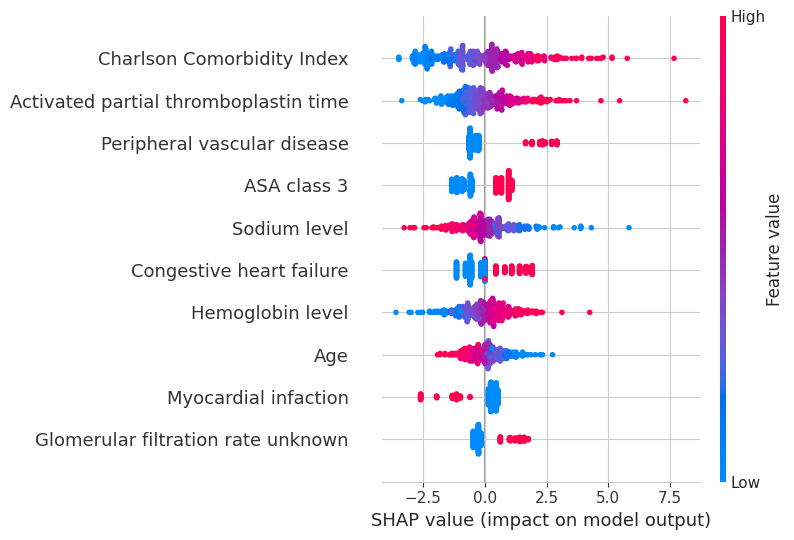

In [17]:
cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)

shap_values_list = []
test_ixs = []

for train_ix, test_ix in cv.split(X, y):
    test_ixs.append(test_ix)
    
    X_tr = X.iloc[train_ix]
    y_tr = y.iloc[train_ix]
    X_te = X.iloc[test_ix]
    y_te = y.iloc[test_ix]
    model.fit(X_tr, y_tr)
    shap_values = get_shap_values(X_te, X_tr, model)
    for shap_value in shap_values:
        shap_values_list.append(shap_value)

new_index = [ix for ix_test_fold in test_ixs for ix in ix_test_fold]
shap.summary_plot(np.array(shap_values_list), X.reindex(new_index), max_display=10, feature_names=fixed_feature_names)

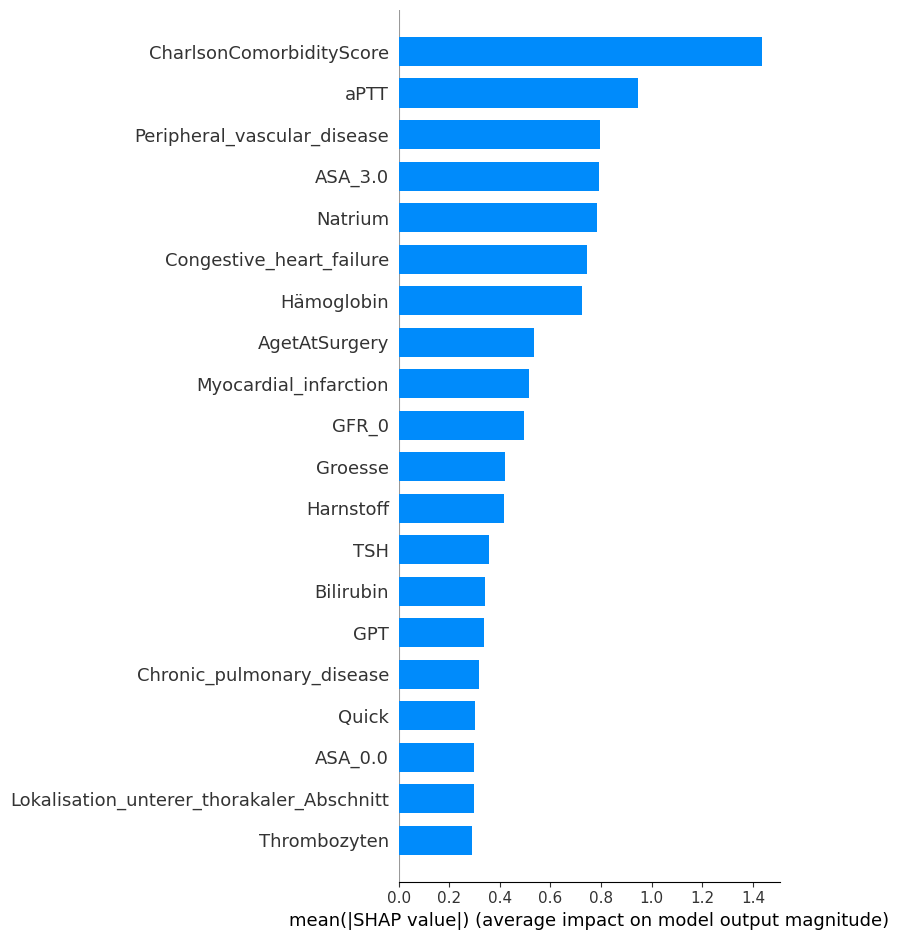

In [12]:
shap.summary_plot(np.array(shap_values_list), X.reindex(new_index), plot_type='bar')

### Validation

In [9]:
sns.set_style('whitegrid')

(148, 74)
(148, 74)


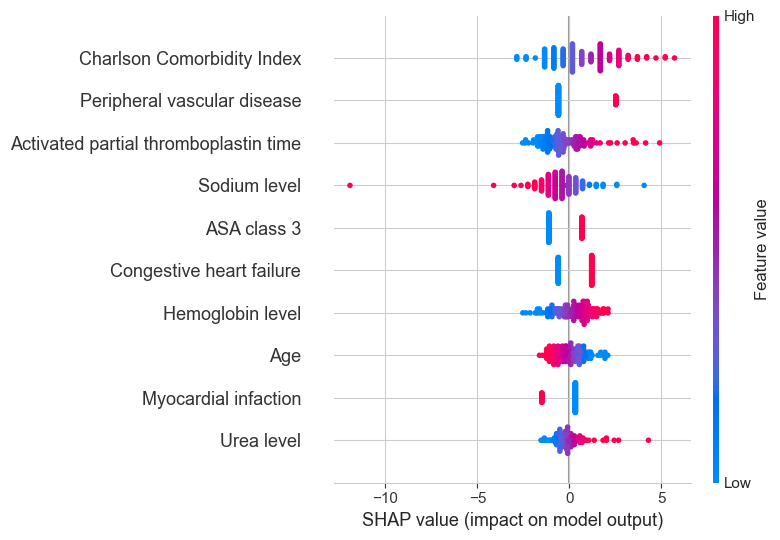

In [19]:
model.fit(X, y)
plt.rcParams['font.family'] = "Arial"
shap_values = get_shap_values(X_val, X, model)
shap.summary_plot(shap_values, X_val, max_display=10, feature_names=fixed_feature_names, show=False)
plt.savefig('../val_shap_plot_10_features_arial.png', dpi=300)

In [15]:
np.mean(np.abs(shap_values), axis=0)

array([0.        , 0.        , 0.41274526, 0.92897441, 0.06903368,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.61168693, 0.        , 1.03592727, 0.        , 0.        ,
       0.        , 0.30963444, 0.        , 0.        , 0.        ,
       0.25155147, 0.        , 0.        , 0.15732736, 0.        ,
       0.10803234, 0.        , 0.        , 0.43794658, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.22613007, 0.        , 0.12632081,
       0.18488539, 0.        , 0.20489174, 0.        , 0.        ,
       0.93266587, 0.        , 0.4690635 , 0.        , 0.23322853,
       0.        , 0.        , 0.        , 0.6333621 , 0.40506132,
       0.02984274, 0.96849118, 0.13729828, 0.52609359, 0.30535088,
       0.25922871, 0.32011246, 0.        , 0.40306506, 0.10936437,
       0.262944  , 0.85163536, 0.01676265, 0.29717245, 0.33581974,
       1.01380455, 1.44890337, 0.        , 0.19494622])

In [214]:
feature_names

Index(['AIDS', 'Cerebrovascular_disease', 'Chronic_pulmonary_disease',
       'Congestive_heart_failure', 'Diabetes_with_chronic_complications',
       'Geschlecht', 'Hemiplegia_or_paraplegia', 'Liver_disease_mild',
       'Liver_disease_moderate_to_severe', 'Metastatic_solid_tumor',
       'Myocardial_infarction', 'Peptic_ulcer_disease',
       'Peripheral_vascular_disease', 'Renal_disease_mild_to_moderate',
       'Renal_disease_severe', 'Rheumatic_disease', 'Histologie_1',
       'Histologie_2', 'Histologie_3', 'Lokalisation_cervikal',
       'Lokalisation_mittlerer_thorakaler_ Abschnitt',
       'Lokalisation_oberer_thorakaler_Abschnitt',
       'Lokalisation_oesophagogastraler_Übergang',
       'Lokalisation_unterer_thorakaler_Abschnitt', 'Vorbehandlung_0',
       'Vorbehandlung_1', 'Vorbehandlung_2', 'Vorbehandlung_3', 'Tpre_0',
       'Tpre_T0', 'Tpre_T1', 'Tpre_T2', 'Tpre_T3', 'Tpre_T4', 'Tpre_Tis',
       'Tpre_Tx', 'Npre_0', 'Npre_N0', 'Npre_N1', 'Npre_N2', 'Npre_N3',
       

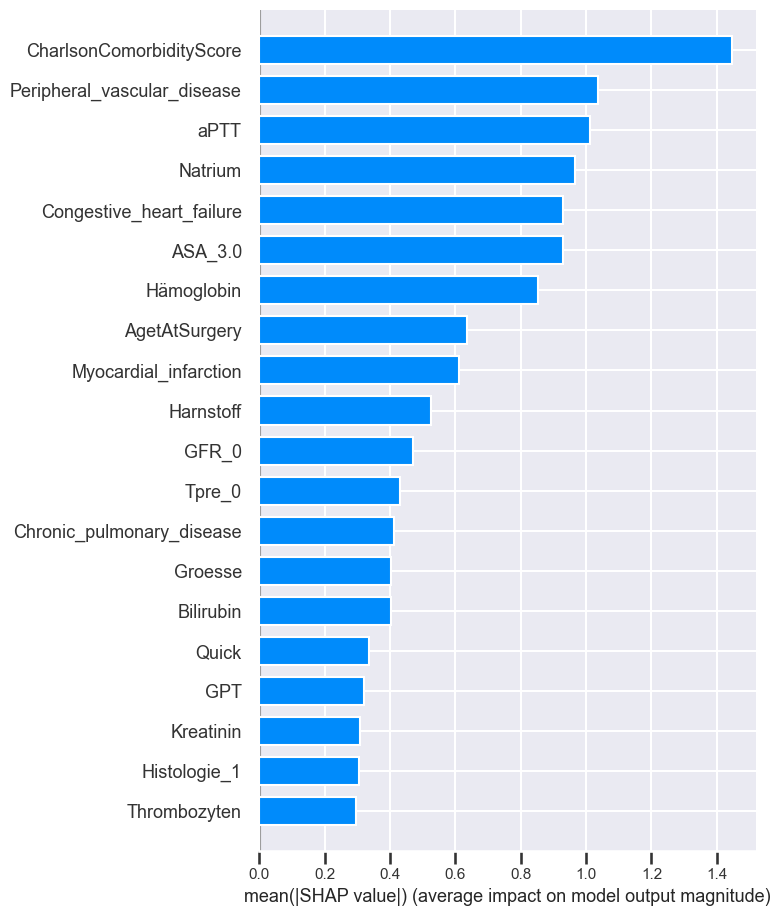

In [200]:
shap.summary_plot(shap_values, X_val, plot_type='bar')

## Feature Importances

In [141]:
import math
#feature_importances = sorted(list(zip(X.columns, map(lambda x: math.pow(math.e, x), model.coef_[0]))), key=lambda x: abs(x[1]), reverse=True)
feature_importances = sorted(list(zip(X.columns, model.coef_[0])), key=lambda x: abs(x[1]), reverse=True)
for f_i in feature_importances:
    if f_i[1] != 1:
        print(f_i)

('Peripheral_vascular_disease', 2.4061109701323966)
('CharlsonComorbidityScore', 1.426742041553036)
('Congestive_heart_failure', 1.3724675233429575)
('GFR_0', 1.3030583641592626)
('ASA_0.0', -1.186336506849536)
('Myocardial_infarction', -1.1552229865963177)
('aPTT', 1.0227147748870815)
('ASA_3.0', 0.9981608188790564)
('Npre_N3', 0.9721274117280809)
('Npre_N2', -0.9527797172727942)
('Natrium', -0.9380166269349698)
('Chronic_pulmonary_disease', 0.7431472746501337)
('Hämoglobin', 0.6415358297526916)
('AgetAtSurgery', -0.605235314803417)
('Groesse', -0.4421533573962865)
('Lokalisation_unterer_thorakaler_Abschnitt', -0.4226642653811669)
('Harnstoff', 0.40484813008882126)
('TSH', -0.40034568688909333)
('Histologie_1', 0.3750583587401464)
('GPT', -0.36186068496287827)
('Quick', 0.3116079134001561)
('Bilirubin', -0.30598629012562145)
('Kreatinin', -0.27741358854409165)
('gamma-GT', 0.25964099981949645)
('CRP', 0.24676662302505492)
('Thrombozyten', -0.2258142245418961)
('GFR_NI_Std2', -0.213967

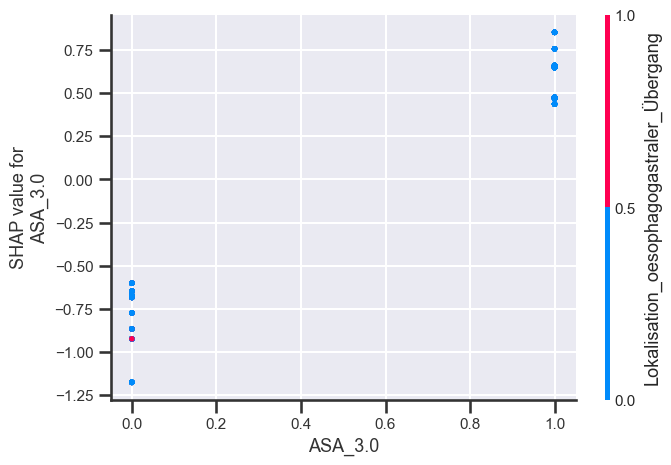

In [201]:
shap.dependence_plot("ASA_3.0", np.array(shap_values_list), X.reindex(new_index))

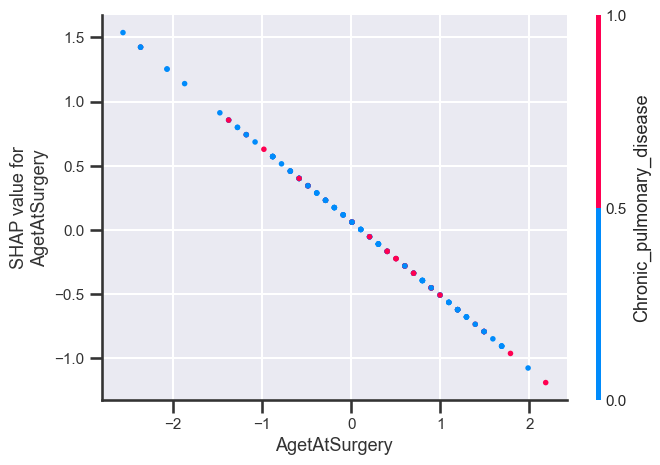

In [162]:
shap.dependence_plot("AgetAtSurgery", shap_values, X_val)

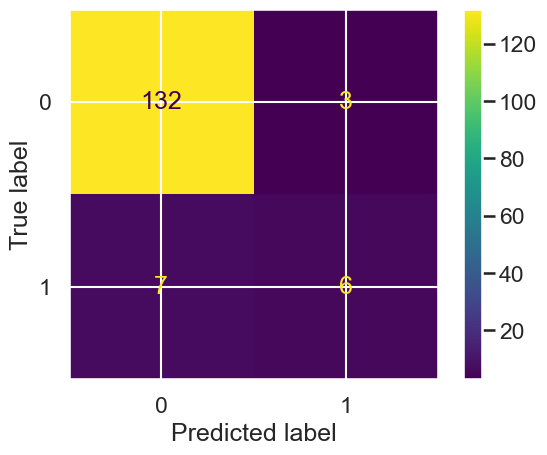

In [133]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

plt.close()
probas = model.predict_proba(X_val)[:, 1]
predictions = to_labels(probas, 0.87)
cm = confusion_matrix(y_val, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot()
plt.show()

# GBM Test

In [240]:
fs = ['Chronic_pulmonary_disease', 'Congestive_heart_failure',
       'Liver_disease_moderate_to_severe', 'Metastatic_solid_tumor',
       'Peripheral_vascular_disease', 'Renal_disease_severe',
       'Rheumatic_disease', 'Histologie_1', 'Lokalisation_cervikal',
       'Vorbehandlung_3', 'Tpre_0', 'Npre_N3', 'ASA_2.0', 'ASA_3.0', 'Natrium',
       'Kalium', 'GOT', 'Lipase', 'CRP', 'Quick', 'INR', 'aPTT',
       'Erythrozyten', 'CharlsonComorbidityScore', 'gamma-GT']
X_fs = X[fs]
X_val_fs = X_val[fs]

  0%|          | 0/148 [00:00<?, ?it/s]

(148, 25)
(148, 25)


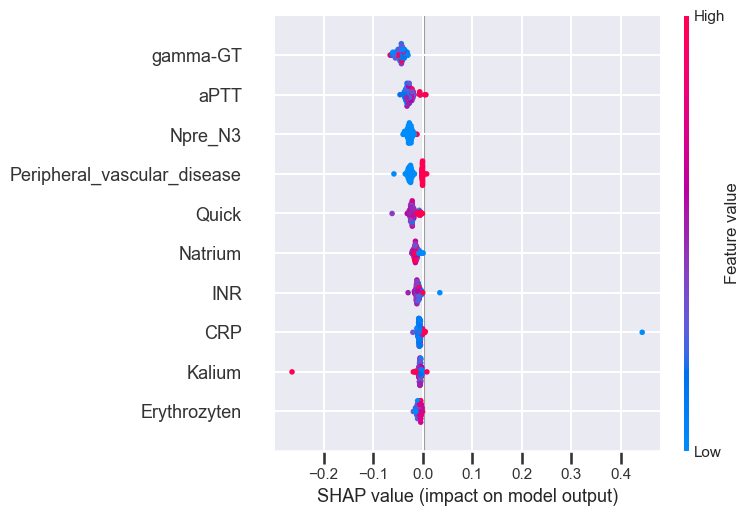

In [249]:
gbm_model = GradientBoostingClassifier(random_state=1111111113,
                                            learning_rate=0.1, loss='exponential', max_depth=5, max_features='log2', n_estimators=100)
gbm_model.fit(X_fs, y)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = get_shap_values(X_val_fs, shap.sample(X_fs, 10), gbm_model)
print(X_val_fs.shape)
print(shap_values.shape)
shap.summary_plot(shap_values, X_val_fs, max_display=10)